# ROZDZIAL 3 - KLASYFIKACJA

## Zbior danych MNIST

In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
mnist = keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
X_train.shape, y_train

((60000, 28, 28), array([5, 0, 4, ..., 5, 6, 8], dtype=uint8))

In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [5]:
digt_8 = X_train[3600]

In [6]:
digt_5 = X_train[11]

Text(0.5, 1.0, '8')

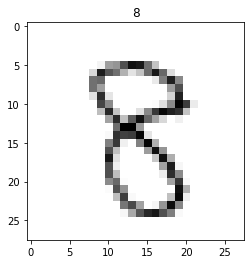

In [7]:
plt.imshow(digt_8, cmap=mpl.cm.binary, interpolation="nearest")
plt.title(y_train[3600], fontsize=12)

Text(0.5, 1.0, '5')

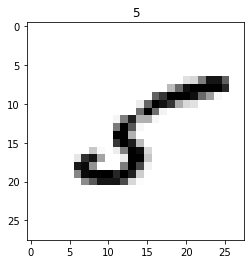

In [8]:
plt.imshow(digt_5, cmap=mpl.cm.binary, interpolation="nearest")
plt.title(y_train[11], fontsize=12)

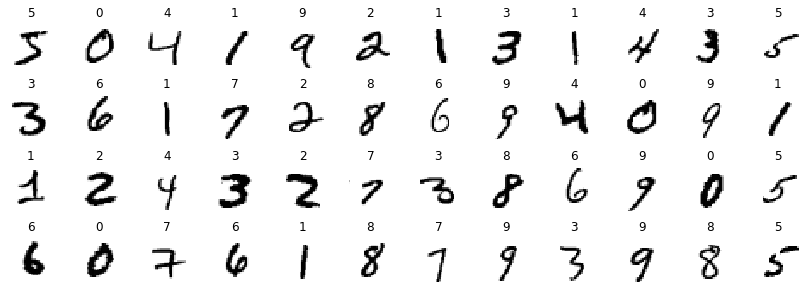

In [9]:
n_rows = 4
n_cols = 12
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap=mpl.cm.binary, interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [10]:
import numpy as np

In [11]:
shuffle_index = np.random.permutation(X_train.shape[0])

In [12]:
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index] # przetasowanie indeksów"

In [13]:
nsamples, nx, ny = X_train.shape
d2_X_train = X_train.reshape((nsamples,nx*ny))

In [14]:
X_train = X_train.reshape((nsamples,nx*ny))

In [15]:
nsamples2, nx2, ny2 = X_test.shape

In [16]:
nsamples2, nx2, ny2

(10000, 28, 28)

In [17]:
X_test = X_test.reshape((nsamples2,nx2*ny2))

## Klasyfiktaor binarny

In [18]:
# klasyfikacja jedynie piatek
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [19]:
y_test_5

array([False, False, False, ..., False,  True, False])

In [20]:
from sklearn.linear_model import SGDClassifier

In [21]:
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42) # klasyfikator stochastycznego spadku wzdluz gradinetu
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [22]:
sgd_clf.predict([digt_8.reshape((nx*ny,))]) # przewiduje wyswietlona 8

array([False])

In [23]:
sgd_clf.predict([digt_5.reshape((nx*ny,))]) # przewiduje wyswietlona piatke

array([ True])

## Miary wydajności

In [24]:
from sklearn.model_selection import cross_val_score

In [25]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96575, 0.9651 , 0.9659 ])

In [26]:
# Własna implementacja cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [27]:
skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.87035
0.9585
0.96945


In [28]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [29]:
# XD bo tylko 10% danych to piatki
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9076 , 0.90985, 0.9115 ])

## Macierz pomylek

In [194]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score

In [31]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [32]:
y_train_pred

array([False,  True, False, ..., False, False, False])

In [33]:
confusion_matrix(y_train_5, y_train_pred)

array([[53768,   811],
       [ 1254,  4167]], dtype=int64)

In [34]:
# TN  FP
# FN  TP

## Precyzja i Pelnosc

In [35]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [36]:
precision_score(y_train_5, y_train_pred)

0.8370831659300924

In [37]:
recall_score(y_train_5, y_train_pred)

0.7686773657996679

In [38]:
f1_score(y_train_5, y_train_pred)

0.8014232137705548

## Komporomis pomiedzy precyzja a pelnoscia

In [39]:
y_scores = sgd_clf.decision_function([digt_5.reshape((nx*ny,))]) # przewiduje wyswietlona 5
y_scores

array([4632.89968907])

In [40]:
threshold = 2000
y_digit_5_predic = (y_scores > threshold)
y_digit_5_predic

array([ True])

In [41]:
threshold = 6000
y_digit_5_predic = (y_scores > threshold)
y_digit_5_predic

array([False])

In [42]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [43]:
from sklearn.metrics import precision_recall_curve

In [44]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [45]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precyzja", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Pełność", linewidth=2)
    plt.legend(fontsize=16)
    plt.grid(True)
    plt.xlabel("Próg", fontsize=16)

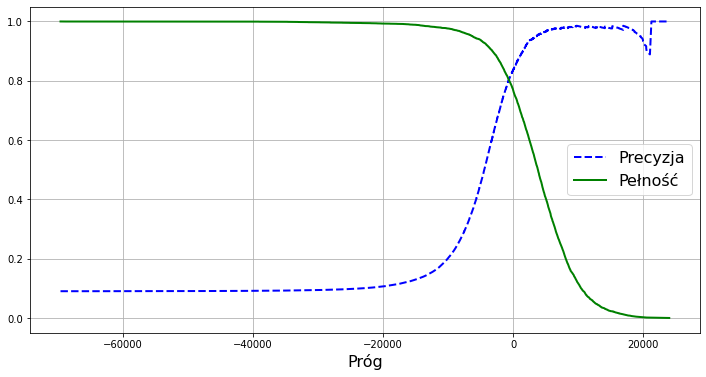

In [46]:
plt.figure(figsize=(12, 6))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [47]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Pełność", fontsize=16)
    plt.ylabel("Precyzja", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

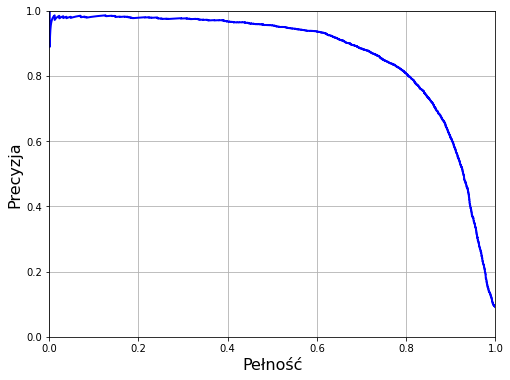

In [48]:
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

## Wykres krzywej ROC

In [49]:
from sklearn.metrics import roc_curve

In [50]:
fpr, tpr, threshold = roc_curve(y_train_5, y_scores)

In [51]:
def plot_roc_curve(fpr, tpr, label=None, color="b"):
    plt.plot(fpr, tpr, color, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1.01, -0.01, 1.01])
    plt.xlabel('Odsetek fałszywie pozytywnych', fontsize=16)
    plt.ylabel('Odsetek prawdziwie pozytywnych', fontsize=16)
    plt.grid(True)


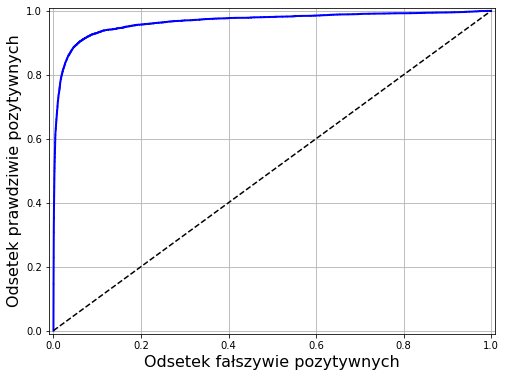

In [52]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

## RandomForest

In [53]:
from sklearn.ensemble import RandomForestClassifier

In [54]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [55]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

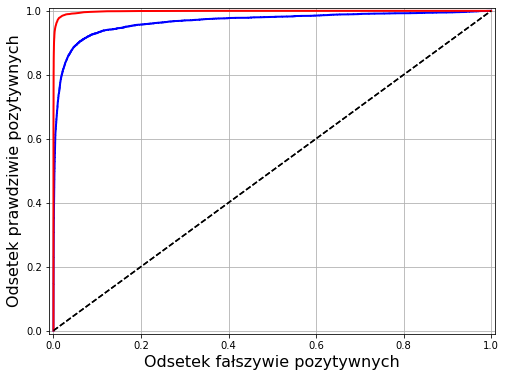

In [56]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr,  "SGD", "b")
plot_roc_curve(fpr_forest, tpr_forest, "Forest", "r")
plt.show()

In [57]:
from sklearn.metrics import roc_auc_score

In [58]:
roc_auc_score(y_train_5, y_scores)

0.9664558304267545

In [59]:
roc_auc_score(y_train_5, y_scores_forest)

0.9984328229419729

In [60]:
y_train_pred_forest = cross_val_predict(forest_clf, d2_X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9903462749213011

In [61]:
recall_score(y_train_5, y_train_pred_forest)

0.8705035971223022

## Klasyfkacja wieloklasowa

In [62]:
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42) # klasyfikator stochastycznego spadku wzdluz gradinetu
sgd_clf.fit(X_train, y_train) # klasyfifkatory same dobierają strategie OvA OvO gdy uzywamy klasyfikacji binarnej

SGDClassifier(random_state=42)

In [63]:
sgd_clf.predict([digt_5.reshape((nx*ny,))]) # przewiduje wyswietlona 8

array([5], dtype=uint8)

In [64]:
sgd_clf.decision_function([digt_5.reshape((nx*ny,))])

array([[-21027.60511044, -21902.55491973,   -351.68062042,
        -14232.49701192,  -2296.94039236,   7796.03771928,
        -15212.15717017, -17070.79151353,   1663.27343844,
         -9424.00940788]])

In [65]:
sgd_clf.predict([digt_8.reshape((nx*ny,))]) # przewiduje wyswietlona 5

array([8], dtype=uint8)

In [66]:
digit_8_scores = sgd_clf.decision_function([digt_8.reshape((nx*ny,))])

In [67]:
digit_8_scores

array([[-12003.04125965, -30191.20485952,  -3867.83988179,
         -4712.13828988,  -8091.44628761,   -642.10801367,
        -13743.39575824, -16313.53472074,   1327.10212691,
         -2797.4443105 ]])

In [68]:
np.argmax(digit_8_scores)

8

In [69]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [70]:
sgd_clf.classes_[8]

8

## Bezpośrednie strategie OvA OvO

In [71]:
from sklearn.multiclass import OneVsOneClassifier

In [72]:
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=1000, tol=1e-3, random_state=42))
ovo_clf.fit(X_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier(random_state=42))

In [73]:
ovo_clf.predict([digt_8.reshape((nx*ny,))]) # przewiduje wyswietlona 8

array([8], dtype=uint8)

In [74]:
ovo_clf.predict([digt_5.reshape((nx*ny,))]) # przewiduje wyswietlona 5

array([5], dtype=uint8)

In [75]:
len(ovo_clf.estimators_) # 10*9/2 tyle kombinacji

45

In [76]:
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [77]:
forest_clf.predict([digt_8.reshape((nx*ny,))]) # przewiduje wyswietlona 8

array([8], dtype=uint8)

In [78]:
forest_clf.predict([digt_5.reshape((nx*ny,))]) # przewiduje wyswietlona 5

array([5], dtype=uint8)

In [79]:
forest_clf.predict_proba([digt_5.reshape((nx*ny,))])

array([[0.  , 0.02, 0.01, 0.01, 0.01, 0.94, 0.01, 0.  , 0.  , 0.  ]])

In [80]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.85595, 0.85845, 0.8848 ])

In [81]:
from sklearn.preprocessing import StandardScaler

In [82]:
# To nie dziala
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

## Analiza bledow

In [83]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5717,    0,   47,   11,    8,   22,   32,    6,   61,   19],
       [   7, 6426,   61,   32,    9,   30,   11,   16,  113,   37],
       [  61,   63, 5133,  180,   73,   28,  108,   87,  194,   31],
       [  33,   18,  329, 4633,   19,  620,   23,   77,  172,  207],
       [  24,   18,   52,   11, 5200,   25,   54,   34,  116,  308],
       [  94,   18,   76,  391,  159, 3965,  133,   33,  368,  184],
       [  66,   13,  100,    4,   47,   60, 5541,    8,   73,    6],
       [  22,   13,   56,   30,   78,   14,    7, 5512,   29,  504],
       [  54,   83,  195,  201,   71,  269,   39,   26, 4596,  317],
       [  37,    8,   32,   51,  187,   56,    3,  218,   96, 5261]],
      dtype=int64)

<Figure size 576x432 with 0 Axes>

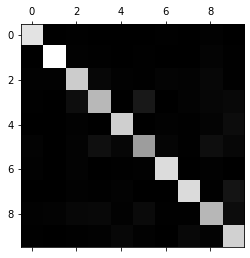

In [84]:
# Rzad to rzeczywiste klasy
# Kolumny to przewidywane
plt.figure(figsize=(8, 6))
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [85]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx /row_sums

In [86]:
np.fill_diagonal(norm_conf_mx, 0)

<Figure size 576x432 with 0 Axes>

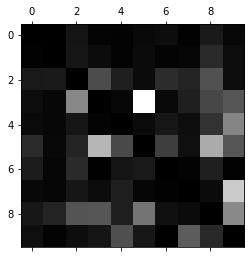

In [87]:
plt.figure(figsize=(8, 6))
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

## Klasyfikacja wieloetykietowa

In [88]:
from sklearn.neighbors import KNeighborsClassifier

In [89]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [90]:
y_multilabel.shape

(60000, 2)

In [91]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [92]:
knn_clf.predict([digt_5.reshape((nx*ny,))])

array([[False,  True]])

In [93]:
knn_clf.predict([digt_8.reshape((nx*ny,))])

array([[ True, False]])

In [94]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [95]:
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9766525342632352

## Klasyfikacja wielowyjsciowa

In [96]:
nx*ny

784

In [97]:
noise =np.random.randint(0, 100, X_train.shape)

In [98]:
noise.shape

(60000, 784)

In [99]:
X_train_mod = X_train + noise

In [100]:
noise =np.random.randint(0, 100, X_test.shape)

In [101]:
noise.shape

(10000, 784)

In [102]:
X_test_mod = X_test + noise

In [103]:
digt_1_mod = X_test_mod[342]

In [104]:
digt_1_train = X_test[342]

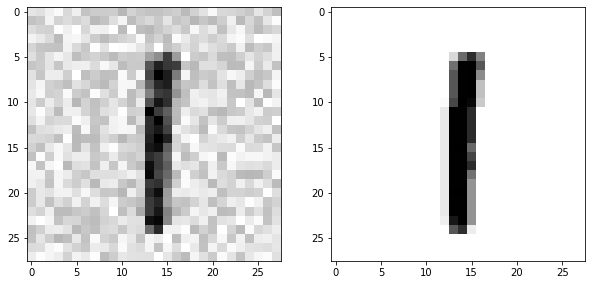

In [105]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(digt_1_mod.reshape((nx2,ny2,)), cmap=mpl.cm.binary, interpolation="nearest")
plt.subplot(1, 2, 2)
plt.imshow(digt_1_train.reshape((nx2,ny2,)), cmap=mpl.cm.binary, interpolation="nearest")

In [106]:
y_train_mod = X_train
y_test_mod = X_test

In [107]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

In [108]:
clean_digit_1 = knn_clf.predict([X_test_mod[342]])

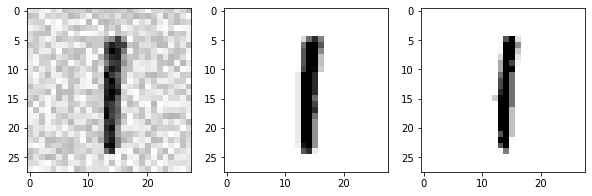

In [109]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(digt_1_mod.reshape((nx2,ny2,)), cmap=mpl.cm.binary, interpolation="nearest")
plt.subplot(1, 3, 2)
plt.imshow(digt_1_train.reshape((nx2,ny2,)), cmap=mpl.cm.binary, interpolation="nearest")
plt.subplot(1, 3, 3)
plt.imshow(clean_digit_1.reshape((nx2,ny2,)), cmap=mpl.cm.binary, interpolation="nearest")

## CWICZENIA

### Zadanie 1


In [130]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd

In [121]:
params = {
    "n_neighbors": [2, 3, 4, 5, 6],
    'weights': ["uniform", "distance"]
}

In [122]:
knn = KNeighborsClassifier(n_jobs=1)
grid = GridSearchCV(knn, params, cv=4)

In [123]:
grid.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=KNeighborsClassifier(n_jobs=1),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6],
                         'weights': ['uniform', 'distance']})

In [127]:
grid.best_params_, grid.best_score_

({'n_neighbors': 4, 'weights': 'distance'}, 0.9725166666666667)

In [132]:
grid.score(X_test, y_test)

0.9714

In [133]:
pd.DataFrame(grid.cv_results_).sort_values(by=['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
5,0.015754,0.002863,18.427637,0.703632,4,distance,"{'n_neighbors': 4, 'weights': 'distance'}",0.971533,0.971600,0.973200,0.973733,0.972517,0.000969,1
3,0.014003,0.002346,14.067158,0.280046,3,distance,"{'n_neighbors': 3, 'weights': 'distance'}",0.969867,0.971800,0.972267,0.973133,0.971767,0.001197,2
1,0.015503,0.001118,13.689324,0.624092,2,distance,"{'n_neighbors': 2, 'weights': 'distance'}",0.969267,0.971467,0.971800,0.974200,0.971683,0.001749,3
9,0.015004,0.005198,17.950780,0.497703,6,distance,"{'n_neighbors': 6, 'weights': 'distance'}",0.969933,0.970867,0.972000,0.972733,0.971383,0.001069,4
7,0.012253,0.000433,17.733983,0.362381,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",0.970133,0.970800,0.971333,0.972400,0.971167,0.000829,5
2,0.013003,0.002916,14.750312,0.533268,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",0.968533,0.971133,0.971333,0.971533,0.970633,0.001221,6
6,0.013253,0.001090,18.480399,0.527240,5,uniform,"{'n_neighbors': 5, 'weights': 'uniform'}",0.967800,0.969800,0.970000,0.971267,0.969717,0.001241,7
4,0.012753,0.001299,18.599972,0.446383,4,uniform,"{'n_neighbors': 4, 'weights': 'uniform'}",0.967933,0.968267,0.969667,0.970400,0.969067,0.001008,8
8,0.011753,0.000433,18.323864,0.452910,6,uniform,"{'n_neighbors': 6, 'weights': 'uniform'}",0.965933,0.968800,0.969667,0.970133,0.968633,0.001631,9
0,0.014003,0.002345,14.097415,0.660736,2,uniform,"{'n_neighbors': 2, 'weights': 'uniform'}",0.961133,0.964400,0.965933,0.967067,0.964633,0.002231,10


### Zadanie 2

In [139]:
from scipy.ndimage import shift

In [140]:
a = X_train[1]
print(a.shape)
a = a.reshape((nx,ny,))
a.shape

(784,)


(28, 28)

In [151]:
b = shift(a, [3, 3], cval=0)
b.shape

(28, 28)

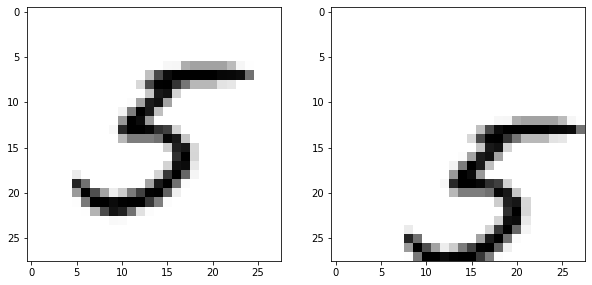

In [149]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(a, cmap=mpl.cm.binary, interpolation="nearest")
plt.subplot(1, 2, 2)
plt.imshow(shift(a, [6, 3], cval=0), cmap=mpl.cm.binary, interpolation="nearest")

In [174]:
def shift_img_all_directions(img, label, dx=1, dy=1):
    img_reshape = img.reshape((nx,ny,))
    img1 = shift(img_reshape, [dx, dy], cval=0).reshape((nx*ny,))
    img2 = shift(img_reshape, [-dx, dy], cval=0).reshape((nx*ny,))
    img3 = shift(img_reshape, [-dx, -dy], cval=0).reshape((nx*ny,))
    img4 = shift(img_reshape, [dx, dy], cval=0).reshape((nx*ny,))
    return ([img1, img2, img3, img4], [label, label, label, label])

In [175]:
y_train[1]

5

In [182]:
X_train_shift_list = [img for img in X_train]
y_train_shift_list = [label for label in y_train]

for img, label in zip(X_train, y_train):
    images, labels = shift_img_all_directions(img, label)
    X_train_shift_list.extend(images)
    y_train_shift_list.extend(labels)

In [183]:
X_train_shift = np.array(X_train_shift_list)
y_train_shift = np.array(y_train_shift_list)

In [188]:
X_train.shape[0]*5, y_train.shape[0]*5

(300000, 300000)

In [189]:
X_train_shift.shape, y_train_shift.shape

((300000, 784), (300000,))

In [190]:
shuffle_idx = np.random.permutation(len(X_train_shift))
X_train_shift = X_train_shift[shuffle_idx]
y_train_shift = y_train_shift[shuffle_idx]

In [192]:
knn = KNeighborsClassifier(**grid.best_params_)
knn.fit(X_train_shift, y_train_shift)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [195]:
y_pred = knn.predict(X_test)
accuracy_score(y_test, y_pred)

0.9737

### Zadanie 2

In [277]:
import os
import seaborn as sns
palette=sns.color_palette("flare")
sns.set(palette=palette)

os.listdir('zestaw_danych/titanic')

['gender_submission.csv', 'test.csv', 'train.csv']

In [278]:
train_data=pd.read_csv('zestaw_danych/titanic/train.csv', index_col='PassengerId')
test_data=pd.read_csv('zestaw_danych/titanic/test.csv', index_col='PassengerId')

In [279]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [280]:
test_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [281]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [282]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [283]:
# Nie potrzebuje Clasy Name i Ticket
train_data_clean = train_data.drop(['Name','Ticket', 'Cabin'], axis=1)

In [284]:
train_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.6+ KB


In [285]:
train_data_clean = train_data_clean[train_data_clean['Embarked'].notna()]

In [286]:
train_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    object 
 3   Age       712 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Fare      889 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.5+ KB


In [287]:
train_data_clean['relatives']=train_data_clean['SibSp']+train_data_clean['Parch']

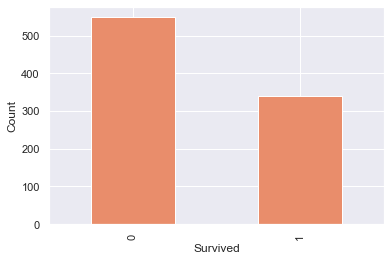

In [288]:
train_data_clean["Survived"].value_counts().plot(kind='bar')
plt.xlabel('Survived')
plt.ylabel('Count')
plt.show()

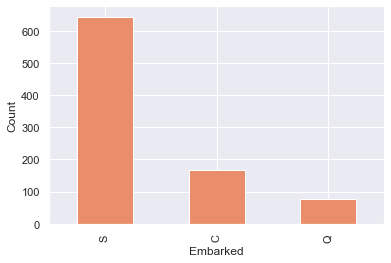

In [289]:
train_data_clean['Embarked'].value_counts().plot(kind='bar')
plt.xlabel('Embarked')
plt.ylabel('Count')
plt.show()

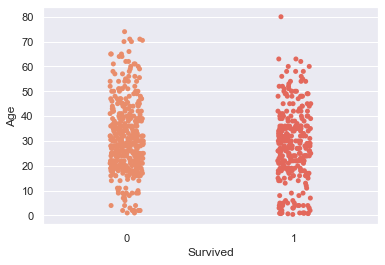

In [290]:
sns.stripplot(data=train_data_clean, x='Survived', y='Age')
plt.show()

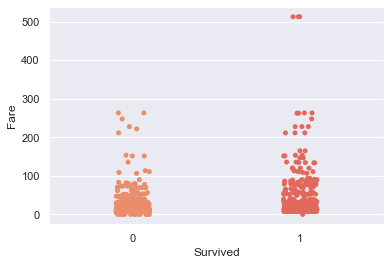

In [291]:
sns.stripplot(data=train_data_clean, x='Survived', y='Fare')
plt.show()

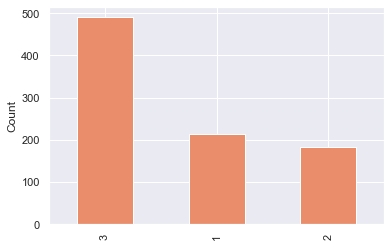

In [292]:
train_data_clean["Pclass"].value_counts().plot(kind='bar')
plt.ylabel('Count')
plt.show()

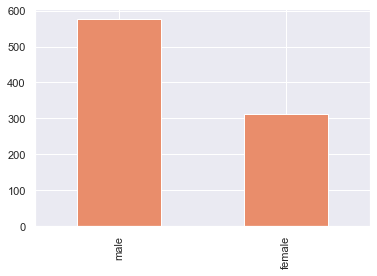

In [293]:
train_data_clean["Sex"].value_counts().plot(kind='bar')
plt.show()

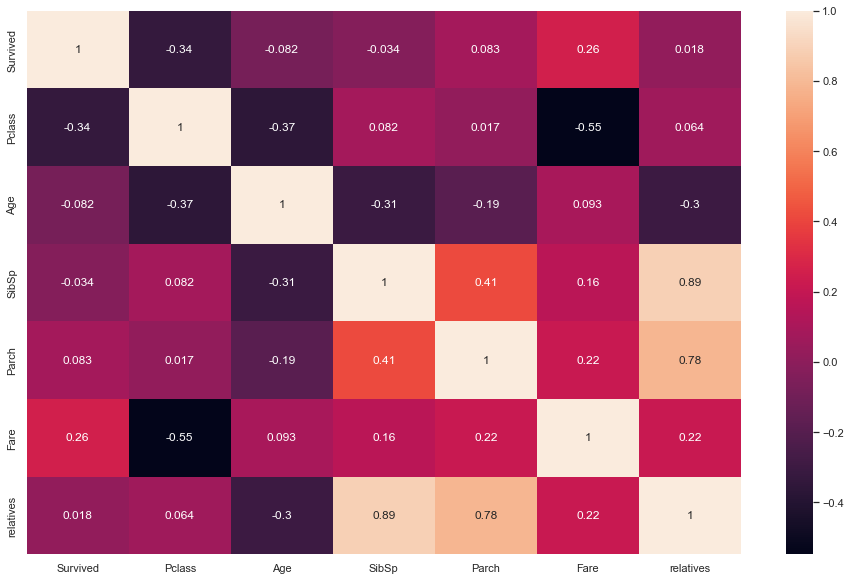

In [294]:
plt.figure(figsize=(16,10))
sns.heatmap(train_data_clean.corr(), annot=True)
plt.show()

In [308]:
X_train = train_data_clean.drop('Survived', axis=1)
y_train = train_data_clean['Survived']

In [309]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives
PassengerId,,,,,,,,
1,3,male,22.0,1,0,7.2500,S,1
2,1,female,38.0,1,0,71.2833,C,1
3,3,female,26.0,0,0,7.9250,S,0
4,1,female,35.0,1,0,53.1000,S,1
5,3,male,35.0,0,0,8.0500,S,0


In [310]:
y_train.head()

PassengerId
1    0
2    1
3    1
4    1
5    0
Name: Survived, dtype: int64

In [298]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

In [311]:
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
categorical_cols

['Sex', 'Embarked']

In [312]:
numerical_cols = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64']]
numerical_cols

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'relatives']

In [313]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [314]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [315]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
                                  'relatives']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Sex', 'Embarked'])])

In [327]:
from sklearn.svm import SVC

In [328]:
svc_clf = SVC(gamma="auto")

In [329]:
svc_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', svc_clf)])
scores_svc = cross_val_score(svc_pipeline, X_train, y_train, cv=10)
print('SVC Scores:',scores_svc)
print('SVC:',scores_svc.mean())

SVC Scores: [0.80898876 0.85393258 0.7752809  0.87640449 0.83146067 0.79775281
 0.82022472 0.78651685 0.85393258 0.85227273]
SVC: 0.8256767109295199


In [330]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [331]:
forest_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', forest_clf)])
scores_forest = cross_val_score(forest_pipeline, X_train, y_train, cv=10)
print('SVC Scores:',scores_forest)
print('SVC:',scores_forest.mean())

SVC Scores: [0.75280899 0.80898876 0.75280899 0.80898876 0.86516854 0.83146067
 0.82022472 0.7752809  0.84269663 0.84090909]
SVC: 0.8099336057201226


In [325]:
forest_2_clf = RandomForestClassifier(max_depth= 6, min_samples_leaf= 1, min_samples_split= 2, random_state=0)

In [332]:
forest_2_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', forest_2_clf)])
scores_forest_2 = cross_val_score(forest_2_pipeline, X_train, y_train, cv=10)
print('SVC Scores:',scores_forest_2)
print('SVC:',scores_forest_2.mean())

SVC Scores: [0.80898876 0.86516854 0.76404494 0.8988764  0.8988764  0.80898876
 0.82022472 0.7752809  0.86516854 0.84090909]
SVC: 0.834652706843718


In [333]:
from sklearn.linear_model import LogisticRegression

In [334]:
log_reg_clf = LogisticRegression(C= 0.1, penalty= 'l2', solver='liblinear',random_state=0)

In [335]:
log_reg_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('model', log_reg_clf)])
scores_log_reg = cross_val_score(log_reg_pipeline, X, y, cv=10)
print('Logistic Regression Scores:',scores_log_reg)
print('Logistic Regression:',scores_log_reg.mean())

Logistic Regression Scores: [0.78651685 0.79775281 0.76404494 0.82022472 0.80898876 0.78651685
 0.78651685 0.78651685 0.82022472 0.84090909]
Logistic Regression: 0.7998212461695607


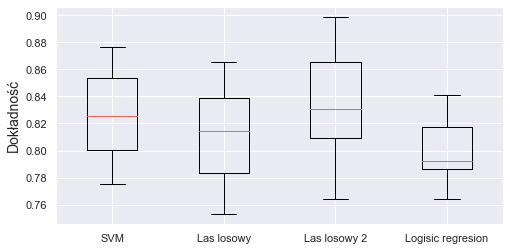

In [339]:
plt.figure(figsize=(8, 4))
plt.boxplot([scores_svc, scores_forest, scores_forest_2, scores_log_reg], labels=("SVM","Las losowy", "Las losowy 2", "Logisic regresion"))
plt.ylabel("Dokładność", fontsize=14)
plt.show()